# Notebook that used for training
Training was performed in google colab on A100 GPU

# Preparations

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import albumentations as A
import random
from typing import List
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [ ]:
def add_spot(image: np.ndarray, seg_mask: np.ndarray, probability=0.5, alpha=0.6) -> np.ndarray:
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    Y_channel = image_ycrcb[:,:,0]

    yellow_color = np.array([255, 255, 0])
    mask_yellow_seg = cv2.inRange(seg_mask, yellow_color, yellow_color)

    brightness_mask = np.uint8((Y_channel > 100) * 255)

    valid_yellow_mask = cv2.bitwise_and(mask_yellow_seg, brightness_mask)

    red_color = np.array([255, 0, 0])
    mask_red_seg = cv2.inRange(seg_mask, red_color, red_color)

    contours_yellow, _ = cv2.findContours(valid_yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_red, _ = cv2.findContours(mask_red_seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    overlay = np.zeros_like(image, dtype=np.uint8)

    for cnt in contours_yellow:
        if random.random() < probability:
            x, y, w, h = cv2.boundingRect(cnt)
            center = (x + w // 2, y + h // 2)
            radius = (min(w, h)) // 2
            cv2.circle(overlay, center, radius, (255, 255, 255), -1)

    for cnt in contours_red:
        if random.random() < probability:
            x, y, w, h = cv2.boundingRect(cnt)
            center = (x + w // 2, y + h // 2)
            radius = (max(w, h)) // 3
            cv2.circle(overlay, center, radius, (255, 255, 255), -1)

    overlay = cv2.GaussianBlur(overlay, (0, 0), sigmaX=5, sigmaY=5)
    combined_mask = cv2.bitwise_or(mask_yellow_seg, mask_red_seg)
    combined_mask_3ch = cv2.merge([combined_mask, combined_mask, combined_mask])
    overlay = cv2.bitwise_and(overlay, combined_mask_3ch)
    result = cv2.addWeighted(image, 1, overlay, alpha, 0)
    return result

In [ ]:
class RoadMarkupsDataset(Dataset):
    def __init__(self, root_dirs: List[str], mask_dirs: List[str], mode: str, custom_transforms=None, custom_transform_p=0.5, transform=None, seed=42):
        self.root_dir = root_dirs
        self.transform: A.Compose = transform
        self.mode = mode
        self.images: List[np.ndarray] = []
        self.custom_transform_p = custom_transform_p
        self.custom_transforms = custom_transforms
        self.masks = []
        self.names_buffer = [os.listdir(dir) for dir in root_dirs]
        self.names = sorted([os.path.join(root_dirs[i], self.names_buffer[i][j]) for i in range(len(root_dirs)) for j in range(len(self.names_buffer[i]))])
        self.mask_names_buffer = [os.listdir(dir) for dir in mask_dirs]
        self.mask_names = sorted([os.path.join(mask_dirs[i], self.mask_names_buffer[i][j]) for i in range(len(mask_dirs)) for j in range(len(self.mask_names_buffer[i]))])
        if mode == 'train':
            random.seed(seed)
            indices = list(range(len(self.names)))
            random.shuffle(indices)
            self.names = [self.names[i] for i in indices]
            self.mask_names = [self.mask_names[i] for i in indices]
        if mode != 'train' and mode != 'valid' and mode != 'test':
            raise ValueError(f'Unknown mode: {mode}')
        self.images = [cv2.cvtColor(cv2.imread(self.names[idx]), cv2.COLOR_BGR2RGB)[-160:,:,:] for idx in tqdm(range(len(self.names)))]
        self.masks = [cv2.cvtColor(cv2.imread(self.mask_names[idx]), cv2.COLOR_BGR2RGB)[-160:,:,:] for idx in tqdm(range(len(self.mask_names)))]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.custom_transforms:
            if random.random() < self.custom_transform_p:
                image, mask = self.custom_transforms(image, mask)
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        tensor_image = torch.from_numpy(image).float().permute(2, 0, 1) / 255
        mask_buffer = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
        mask_buffer[np.all(mask == [255, 255, 255], axis=-1)] = 1
        mask_buffer[np.all(mask == [255, 255, 0], axis=-1)] = 2
        mask_buffer[np.all(mask == [255, 0, 0], axis=-1)] = 3
        tensor_mask = torch.from_numpy(mask_buffer)

        return tensor_image, tensor_mask

In [ ]:
class BasicMobileNetBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, leaky_relu_coef=0, dropout=0.3, kernel_size=3):
        super().__init__()
        self.spatial_convolve = torch.nn.Conv2d(
            in_dim,
            in_dim,
            kernel_size,
            padding=kernel_size // 2,
            padding_mode="zeros",
            groups=in_dim,
        )
        self.depthwise_convolve = torch.nn.Conv2d(
            in_dim,
            out_dim,
            kernel_size=1,
        )
        if leaky_relu_coef == 0:
            self.ReLU = torch.nn.ReLU()
        else:
            self.ReLU = torch.nn.LeakyReLU(leaky_relu_coef)
        self.batch_norm = torch.nn.BatchNorm2d(out_dim)
        self.dropout = torch.nn.Dropout2d(p=dropout)

    def forward(self, X):
        _X = self.spatial_convolve(X)
        _X = self.depthwise_convolve(X)
        _X = self.batch_norm(_X)
        _X = self.ReLU(_X)
        return self.dropout(_X)

class MySegmentationNet(torch.nn.Module):
    def __init__(self, block_amount=2, leaky_relu_coef=0, dropout=0.3, kernel_size=3):
        super().__init__()
        self.in_layer = BasicMobileNetBlock(3, 64, leaky_relu_coef=0, dropout=0.3, kernel_size=3)
        self.basic_layers = torch.nn.Sequential()
        for i in range(block_amount):
            self.basic_layers.append(BasicMobileNetBlock(64, 64, leaky_relu_coef=0, dropout=0.3, kernel_size=3))
        self.out_layer = torch.nn.Conv2d(64, 4, 1)

    def forward(self, X):
        _X = self.in_layer(X)
        _X = self.basic_layers(_X)
        return self.out_layer(_X)

In [ ]:
class Recall(torch.nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target

    def forward(self, gt, pred):
        gt_positive = gt == self.target
        TP = (pred[gt_positive] == self.target).sum()
        FN = (~(pred[gt_positive] == self.target)).sum()
        return (TP + 1) / (TP + FN + 1)


class Precision(torch.nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target

    def forward(self, gt, pred):
        gt_positive = gt == self.target
        TP = (pred[gt_positive] == self.target).sum()
        FP = (pred[~gt_positive] == self.target).sum()
        return (TP + 1) / (TP + FP + 1)

In [ ]:
import torchmetrics

class Trainer(pl.LightningModule):
    def __init__(
            self,
            model,
            opt='adam',
            red_weight=5.0,
            white_weight=5.0,
            yellow_weight=5.0,
    ):
        super().__init__()
        self.opt = opt

        self.model = model
        self.loss = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, white_weight, yellow_weight, red_weight]))
        self.val_recal_red = Recall(3)
        self.val_precision_red = Precision(3)
        self.val_recal_yellow = Recall(2)
        self.val_precision_yellow = Precision(2)
        self.val_recal_white = Recall(1)
        self.val_precision_white = Precision(1)
        self.is_first = True


    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        """The full training loop"""
        if self.is_first:
            print("Starting training...")
        x, y = batch

        y_pred = self.model(x)
        loss = self.loss(y_pred, y)

        metrics = {"train_loss": loss}
        self.log_dict(metrics, prog_bar=True, on_step=True, on_epoch=True, logger=True)
        if self.is_first:
            print("First itteration finished")
            self.is_first = False
        return loss

    def configure_optimizers(self):
        """Define optimizers and LR schedulers."""
        if self.opt == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=5e-4)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr=1e-3, momentum=0.9)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.1,
            patience=2,
            verbose=True,
        )
        lr_dict = {
            "scheduler": lr_scheduler,
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss",
        }

        return [optimizer], [lr_dict]

    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch

        y_pred = self.model(x)

        # print(y_pred)
        y_pred_label = torch.argmax(y_pred, dim=1)
        y_label = y

        loss = self.loss(y_pred, y)

        red_recal = self.val_recal_red(y_label, y_pred_label)
        red_precision = self.val_precision_red(y_label, y_pred_label)
        yellow_recal = self.val_recal_yellow(y_label, y_pred_label)
        yellow_precision = self.val_precision_yellow(y_label, y_pred_label)
        white_recal = self.val_recal_white(y_label, y_pred_label)
        white_precision = self.val_precision_white(y_label, y_pred_label)

        metrics = {
            "val_loss": loss,
            "red_recal": red_recal,
            "red_precision": red_precision,
            "yellow_recal": yellow_recal,
            "yellow_precision": yellow_precision,
            "white_recal" : white_recal,
            "white_precision" : white_precision,
        }
        self.log_dict(metrics, prog_bar=True, on_step=True, on_epoch=True, logger=True)

        return metrics

# Training

In [ ]:
# TODO Change paths
train_data_dirs = ["/path/to/train/data/dir"]
train_mask_dirs = ["/path/to/train/masks/dir"]

valid_data_dirs = ["/path/to/valid/data/dir"]
valid_mask_dirs = ["/path/to/valid/masks/dir"]
transforms = A.Compose(
    [
        A.Compose([
            A.HorizontalFlip(p=.5),
        ]),
        A.OneOf([
            A.RGBShift(
                r_shift_limit=(-50, 50),
                b_shift_limit=(-50, 50),
                g_shift_limit=(-50, 50),
                p=1.0
            ),
            A.HueSaturationValue(
                hue_shift_limit=(-20, 20),
                sat_shift_limit=(-50, 50),
                val_shift_limit=(-50, 50),
                p=1.0
            )
        ], p=.5),
        A.RandomGravel(gravel_roi=(0.1, 0.1, 0.9, 0.9), number_of_patches=5, p=0.5),
        A.OneOf([
            A.RandomGamma(p=1.0, gamma_limit=(199, 200)),
            A.RandomShadow(shadow_roi=(0.2, 0.2, 0.8, 0.8), num_shadows_limit=(3, 5), shadow_dimension=7, shadow_intensity_range=(0.1, 0.3), p=1.0)
        ], p=.5),
        A.RandomFog(alpha_coef=0.9, fog_coef_range=(0.1, 0.2), p=.5),

    ]
)



def custom_transforms(image, mask):
    image = add_spot(image, mask, probability=0.3, alpha=0.6)
    return image, mask

ds_train = RoadMarkupsDataset(train_data_dirs, train_mask_dirs, "train", transform=transforms, custom_transforms=custom_transforms)
ds_val = RoadMarkupsDataset(valid_data_dirs, valid_mask_dirs, "valid")

In [ ]:
BATCH_SIZE = 64
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [ ]:
MyNetCheckpoint = ModelCheckpoint(
    dirpath="/path/to/checkpoints/", # TODO Change path
    filename="{epoch}-{val_loss:.3f}",
    save_top_k=2,
    mode="min",
    monitor="val_loss",
    every_n_epochs=1,
    save_last=True
)

MyEarlyStopping = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=True)

In [ ]:
torch.set_float32_matmul_precision('high')

In [ ]:
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    callbacks=[MyEarlyStopping, MyNetCheckpoint],
    log_every_n_steps=50,
)

training_module = Trainer(
    model=MySegmentationNet(),
    yellow_weight=7.0
)

trainer.fit(training_module, dl_train, dl_val)

# Testing

In [ ]:
class AccuracySum(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, gt, pred):
        return (gt == pred).sum()

class Accuracy(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, gt, pred):
        return (gt == pred).float().mean()

In [ ]:
def calculate_truth_matrix(target, gt, pred):
    gt_positive = gt == target
    TP = (pred[gt_positive] == target).sum()
    FP = (pred[~gt_positive] == target).sum()
    FN = (~(pred[gt_positive] == target)).sum()
    return TP, FP, FN

In [ ]:
test_dirs = ["/path/to/test/data/dir"] # TODO Change path
mask_dirs = ["/path/to/test/masks/dir"] # TODO Change path
ds_test = RoadMarkupsDataset(test_dirs, mask_dirs, "test")

In [ ]:
import gc
import time
def testing(model, dataset, device):
    model.eval()
    model.to(device)
    dl_test = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count())
    recal_red = Recall(3)
    precision_red = Precision(3)
    recal_yellow = Recall(2)
    precision_yellow = Precision(2)
    recal_white = Recall(1)
    precision_white = Precision(1)
    accuracy_func = Accuracy()
    accuracy_sum = AccuracySum()
    metrics = {
        "accuracy": 0,
        "red_recal": 0,
        "red_precision": 0,
        "yellow_recal": 0,
        "yellow_precision": 0,
        "white_recal" : 0,
        "white_precision" : 0,
    }
    rTP, rFP, rFN = 0.0, 0.0, 0.0
    yTP, yFP, yFN = 0.0, 0.0, 0.0
    wTP, wFP, wFN = 0.0, 0.0, 0.0

    recal_red_mean_per_picture = 0.0
    precision_red_mean_per_picture = 0.0
    recal_yellow_mean_per_picture = 0.0
    precision_yellow_mean_per_picture = 0.0
    recal_white_mean_per_picture = 0.0
    precision_white_mean_per_picture = 0.0

    accuracy = 0

    accuracy_mean_per_picture = 0.0

    pictures_amount = 0
    time_delta = 0

    with torch.no_grad():
        for batch in tqdm(dl_test):
            x, y = batch
            x = x.to(device)
            pictures_amount += y.size()[0]
            time_start = time.time_ns()
            y_pred_gpu = model(x)
            time_end = time.time_ns()
            time_delta += time_end - time_start
            y_pred = y_pred_gpu.to(torch.device("cpu"))
            y_pred_label = torch.argmax(y_pred, dim=1)
            _rTP, _rFP, _rFN = calculate_truth_matrix(3, y, y_pred_label)
            _yTP, _yFP, _yFN = calculate_truth_matrix(2, y, y_pred_label)
            _wTP, _wFP, _wFN = calculate_truth_matrix(1, y, y_pred_label)
            rTP += _rTP
            rFP +=_rFP
            rFN +=_rFN
            yTP += _yTP
            yFP +=_yFP
            yFN +=_yFN
            wTP += _wTP
            wFP +=_wFP
            wFN +=_wFN

            accuracy += accuracy_sum(y, y_pred_label)

            recal_red_mean_per_picture += value if not np.isnan(value := recal_red(y, y_pred_label).item()) else 1.0
            precision_red_mean_per_picture += value if not np.isnan(value := precision_red(y, y_pred_label).item()) else 1.0
            recal_yellow_mean_per_picture += value if not np.isnan(value := recal_yellow(y, y_pred_label).item()) else 1.0
            precision_yellow_mean_per_picture += value if not np.isnan(value := precision_yellow(y, y_pred_label).item()) else 1.0
            recal_white_mean_per_picture += value if not np.isnan(value := recal_white(y, y_pred_label).item()) else 1.0
            precision_white_mean_per_picture += value if not np.isnan(value := precision_white(y, y_pred_label).item()) else 1.0
            accuracy_mean_per_picture += accuracy_func(y, y_pred_label)
            del x
            del y
            del y_pred
            del y_pred_label
            gc.collect()
            torch.cuda.empty_cache()
    metrics = {
        "accuracy": accuracy / (pictures_amount * 640 * 160),
        "red_recal": rTP / (rTP + rFN),
        "red_precision": rTP / (rTP + rFP),
        "yellow_recal": yTP / (yTP + yFN),
        "yellow_precision": yTP / (yTP + yFP),
        "white_recal" : wTP / (wTP + wFN),
        "white_precision" : wTP / (wTP + wFP),

        "accuracy_mean_per_picture": accuracy_mean_per_picture / pictures_amount,
        "red_recal_mean_per_picture": recal_red_mean_per_picture / pictures_amount,
        "red_precision_mean_per_picture": precision_red_mean_per_picture / pictures_amount,
        "yellow_recal_mean_per_picture": recal_yellow_mean_per_picture / pictures_amount,
        "yellow_precision_mean_per_picture": precision_yellow_mean_per_picture / pictures_amount,
        "white_recal_mean_per_picture" : recal_white_mean_per_picture / pictures_amount,
        "white_precision_mean_per_picture" : precision_white_mean_per_picture / pictures_amount,
        "time_delta": time_delta / pictures_amount,
    }
    del model
    del dl_test
    gc.collect()
    torch.cuda.empty_cache()
    return metrics


In [ ]:
metrics = testing(trainer.model, ds_test, torch.device("cuda"))

In [ ]:
metrics

In [ ]:
torch.save(trainer.model.state_dict(), "/path/to/model.pt") # TODO Change path

In [1]:
import matplotlib.pyplot as plt
import cv2

/home/Ilia.Nechaev/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


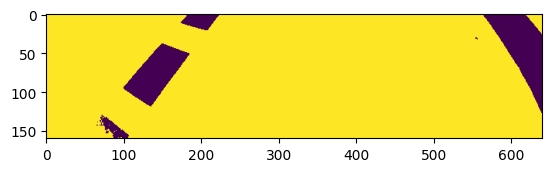

In [4]:
img = cv2.imread("out.png", cv2.IMREAD_UNCHANGED)
plt.imshow(img)

In [6]:
import numpy as np
np.unique(img)

array([  0, 255], dtype=uint8)